# Q1 Dimensionality Reduction on Data Feature

## Reference

* PCA中降维数确定方法: http://blog.sina.com.cn/s/blog_628cc2b70102xq70.html
* python大战机器学习——数据降维: https://www.cnblogs.com/acm-jing/p/7528874.html
* 非平衡数据的处理 SMOTE: https://www.cnblogs.com/xyou/p/9075443.html
* Wikipedia: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Locally-linear_embedding
* LLE Algorithm Pseudocode: https://cs.nyu.edu/~roweis/lle/algorithm.html
* 机器学习降维算法三：LLE (Locally Linear Embedding) 局部线性嵌入: https://www.cnblogs.com/xbinworld/archive/2012/07/09/LLE.html
* LLE降维: http://www.luyixian.cn/news_show_304405.aspx

In [99]:
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [7]:
data = loadmat("Q1.mat")
X = data['X']
y = data['y'].ravel()

In [8]:
# Show the number of positive samples and negative samples
print("Number of positive samples = %s" % sum(y==1))
print("Number of negative samples = %s" % sum(y==0))

Number of positive samples = 61
Number of negative samples = 3625


We find that the dataset is highly imbalanced so we will use `SMOTE` algorithm to rebuild dataset.

In [9]:
smote = SMOTE(random_state=0) 
X_smote, y_smote = smote.fit_sample(X, y)

In [10]:
print("Number of positive samples = %s" % sum(y_smote==1))
print("Number of negative samples = %s" % sum(y_smote==0))

Number of positive samples = 3625
Number of negative samples = 3625


## Find the ideal number of dimensions that reduce

Then we can find that if we keep about 90% of information, we can keep about `250` dimensions.

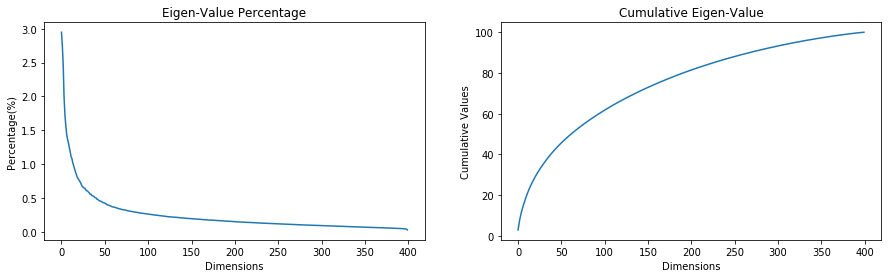

In [11]:
# Split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)

# Standardization
X_std = StandardScaler().fit_transform(X_train)

# Compute eigen-vector and eigen-value
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Build a pair for (eigen-value and eigen-vector)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort eigen-vector from big to small
eig_pairs.sort(key = lambda x: x[0], reverse=True)

# Compute 
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Plot
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

plt.sca(ax1)
plt.title("Eigen-Value Percentage")
plt.xlabel("Dimensions")
plt.ylabel("Percentage(%)")
plt.plot(var_exp)

plt.sca(ax2)
plt.title("Cumulative Eigen-Value")
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Values")
plt.plot(cum_var_exp)
plt.show()

In [106]:
def classification_test(X_train_reduced, y_train, X_test_reduced, y_test):
    # Logistic Regression Model
    LR = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='multinomial')
    LR.fit(X_train_reduced, y_train)
    y_pred = LR.predict(X_test_reduced) # do predict on testing set
    print("Logistic Regression Testing")
    print(classification_report(y_test, y_pred)) # Show the evaluation result
    
    # LightGBM Model
    lgb = LGBMClassifier(boosting_type='gbdt', max_depth=None, learning_rate=1e-2, n_estimators=5)
    lgb.fit(X_train_reduced, y_train)
    y_pred = lgb.predict(X_test_reduced) # do predict on testing set
    print("LightGBM Testing")
    print(classification_report(y_test, y_pred)) # Show the evaluation result
    
    # Random Forest Model
    rf = RandomForestClassifier(n_estimators=5, random_state=0, max_depth=2)
    rf.fit(X_train_reduced, y_train)
    y_pred = rf.predict(X_test_reduced) # do predict on testing set
    print("Random Forest Testing")
    print(classification_report(y_test, y_pred)) # Show the evaluation result

## Principal Component Analysis (PCA)

In [14]:
def pca(XMat, k):
    """
    The PCA function
    
    Input:
        XMat: shape = (|X|, d), |X| the number of samples, d the number of features
        k: takes the first k eigenvectors
    Output:
        finalData: the matrix with lower dimensions
        reconData: the matrix after moving axis
    """
    average = np.mean(XMat, axis=0) 
    m, n = np.shape(XMat)
    data_adjust = []
    avgs = np.tile(average, (m, 1))
    data_adjust = XMat - avgs
    
    # Compute covariance maxtrix
    covX = np.cov(data_adjust.T)
    
    # Compute the eigenvalue and eigenvector
    featValue, featVec=  np.linalg.eig(covX)
    
    # Sort the eigenvalue from big to small
    index = np.argsort(-featValue)
    
    finalData = []
    if k > n:
        print("k must lower than feature number")
        return
    else:
        selectVec = np.matrix(featVec.T[index[:k]]) 
        finalData = data_adjust * selectVec.T 
        reconData = (finalData * selectVec) + average  
    return finalData, reconData

In [ ]:
X_train_PCA, X_train_PCA_recon = pca(X_train, 250)
X_test_PCA, X_test_PCA_recon = pca(X_test, 250)

In [107]:
classification_test(X_train_PCA, y_train, X_test_PCA, y_test)

Logistic Regression Testing
              precision    recall  f1-score   support

           0       0.52      0.76      0.61       699
           1       0.60      0.34      0.43       751

    accuracy                           0.54      1450
   macro avg       0.56      0.55      0.52      1450
weighted avg       0.56      0.54      0.52      1450

LightGBM Testing
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       699
           1       0.89      0.60      0.71       751

    accuracy                           0.75      1450
   macro avg       0.78      0.76      0.75      1450
weighted avg       0.79      0.75      0.75      1450

Random Forest Testing
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       699
           1       0.90      0.81      0.85       751

    accuracy                           0.85      1450
   macro avg       0.86      0.86      0.85      1450
weighte

## Locally Linear Embedding (LLE)

In [98]:
def get_k_maxtria(D, k):
    '''
    define get_k_maxtria function.
    Input:
        D：numpy.ndarry,  size: [num_sample, num_feature]
        k: float,  the nearest neighbor parameter k
    Return:
        k_idx: numpy.ndarry,  size: [num_sample, k], the index of the k nearest neighbor
    '''
    
    dist = pdist(D, 'euclidean')
    dist = squareform(dist)
    m = dist.shape[0]
    k_idx = np.zeros([m, k])
    for i in range(m):
        topk = np.argsort(dist[i])[1:k + 1]
        k_idx[i] = k_idx[i] + topk

    return k_idx.astype(np.int32)


def get_w(D, knear_idx, k):
    '''
    define get_w function.
    
    Input:
        D：numpy.ndarry,  size: [num_sample, num_feature]
        kear_idx: numpy.ndarry,  size: [num_sample, k]
        k: float,  the nearest neighbor parameter k
    Return:
        w: numpy.ndarry,  size: [num_sample, k], Linear reconstruction coefficient matrix
    '''
    
    m = D.shape[0]
    w = np.zeros([m, k])
    I = np.ones((k, 1))
    for i in range(m):
        Q_x = D[knear_idx[i]]       
        xi = D[i]              
        xi = np.tile(xi, (k,1))   
        C = np.dot((xi - Q_x), (xi-Q_x).T)    
        C = C +np.eye(k)*(1e-3)*np.trace(C)
        C_inv = np.linalg.pinv(C)
        w[i,:] = np.sum(C_inv, axis=0)/np.sum(C_inv)    

    return w
    
      
def lle(D, k=5, d=2):
    '''
    define lle function.
    Input:
        D：numpy.ndarry,  size: [num_sample, num_feature], the sample set D
        k: float,  default=5, the nearest neighbor parameter k
        d: float,  default=2, the dimension after dimensionality reduction
    Return:
        Z: numpy.ndarry,  size: [num_sample, d], The projection of the sample set D in a low-dimensional space
    '''     
    m = D.shape[0]
    knear_idx = get_k_maxtria(D, k)
    w = get_w(D, knear_idx, k)            
    W = np.zeros([m,m])
    for i in range(m):
        for j in range(k):
            idx = knear_idx[i, j]
            W[i, idx] = w[i, j]
    I = np.eye(m)
    M = np.dot((I-W).T, (I-W))
    A, U = np.linalg.eig(M)
    top_A_idx = np.argsort(A)[1:d+1]
    Z = U[:,top_A_idx]
    
    return Z

In [101]:
X_train_LLE = lle(X_train,k=5,d=250)

In [100]:
X_test_LLE = lle(X_test,k=5,d=250)

In [108]:
classification_test(X_train_LLE.astype('float'), y_train, X_test_LLE.astype('float'), y_test)

C:\Users\yelbee\Anaconda3\envs\pytorch15\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Logistic Regression Testing
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       699
           1       0.61      0.42      0.50       751

    accuracy                           0.56      1450
   macro avg       0.57      0.57      0.55      1450
weighted avg       0.57      0.56      0.55      1450

LightGBM Testing
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       699
           1       0.57      0.57      0.57       751

    accuracy                           0.55      1450
   macro avg       0.55      0.55      0.55      1450
weighted avg       0.55      0.55      0.55      1450

Random Forest Testing
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       699
           1       0.61      0.56      0.58       751

    accuracy                           0.58      1450
   macro avg       0.59      0.59      0.58      1450
weighte